In [143]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [144]:
class SimpleUPLEnvironment:
    """
    Entorno simple del problema Ultimate Pit Limit (UPL) en forma de T.
    Simula 4 bloques con restricciones de precedencia y valores aleatorios.
    """
    def __init__(self, seed=123):
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)

        # Definir los bloques: (fila, columna)
        self.blocks = {
            (0, 0): "B1",
            (0, 1): "B2",
            (0, 2): "B3",
            (1, 1): "B4"
        }

        self.block_values = {pos: np.random.randint(10, 100) for pos in self.blocks}
        self.reset()

    def reset(self):
        """
        Reinicia el entorno a su estado inicial: posición del agente y bloques no extraídos.
        """
        self.agent_pos = (0, 0)  # Empieza en B1
        self.extracted = {pos: False for pos in self.blocks}
        return self.get_state()

    def get_state(self):
        """
        Retorna el estado actual como una tupla:
        - Posición del agente
        - Tupla booleana con bloques extraídos
        """
        # Estado como: ((fila, col), tuple de extraídos)
        extracted_tuple = tuple(self.extracted[pos] for pos in sorted(self.blocks))
        return (self.agent_pos, extracted_tuple)

    def is_valid_position(self, pos):
        """
        Verifica si la posición corresponde a un bloque válido.
        """
        return pos in self.blocks

    def can_extract(self, pos):
        """
        Verifica si el agente puede extraer un bloque cumpliendo las restricciones.
        """
        if self.extracted[pos]:
            return False  # Ya extraído
        if pos == (1, 1):  # B4: necesita B1, B2, B3 extraídos
            return self.extracted[(0, 0)] and self.extracted[(0, 1)] and self.extracted[(0, 2)]
        return True  # B1, B2, B3 no tienen restricciones

    def render_matplotlib(self, ax=None):
        """
        Visualiza el estado actual del entorno usando matplotlib.
        :param ax: Ejes de matplotlib opcionales para graficar.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 4))
        ax.clear()

        colors = {
            False: "skyblue",  # bloque no extraído
            True: "gray",      # bloque extraído
        }

        for (row, col), name in self.blocks.items():
            value = self.block_values[(row, col)]
            extracted = self.extracted[(row, col)]
            color = colors[extracted]

            rect = patches.Rectangle((col, -row), 1, 1, linewidth=1, edgecolor='black', facecolor=color)
            ax.add_patch(rect)
            ax.text(col + 0.5, -row + 0.5, f"{name}\n${value}", ha='center', va='center', fontsize=10)

        # Dibujar agente
        ax.plot(self.agent_pos[1] + 0.5, -self.agent_pos[0] + 0.5, "ro", markersize=12)

        ax.set_xlim(-0.5, 3)
        ax.set_ylim(-2, 0.5)
        ax.set_aspect('equal')
        ax.axis('off')
        plt.pause(0.3)

    def step(self, action):
        """
        Ejecuta una acción, actualiza el entorno y retorna:
        - nuevo estado
        - recompensa
        - si el episodio terminó
        """
        reward = -1  # penalización por paso por defecto
        done = False

        row, col = self.agent_pos

        if action == "up":
            new_pos = (row - 1, col)
        elif action == "down":
            new_pos = (row + 1, col)
        elif action == "left":
            new_pos = (row, col - 1)
        elif action == "right":
            new_pos = (row, col + 1)
        elif action == "extract":
            if self.agent_pos in self.blocks:
                if self.can_extract(self.agent_pos):
                    self.extracted[self.agent_pos] = True
                    reward = self.block_values[self.agent_pos]
                    print(f"Extrajo {self.blocks[self.agent_pos]} ({self.agent_pos}) con valor {reward}")
                    if all(self.extracted.values()):
                        done = True  # terminó si extrajo todo
                else:
                    reward = -100  # penalización por extracción ilegal
                    print(f"Extracción ilegal en {self.agent_pos} - Penalización")
            return self.get_state(), reward, done
        else:
            print("Acción inválida:", action)
            return self.get_state(), -10, False  # acción inválida

        # Moverse si la nueva posición es válida
        if self.is_valid_position(new_pos):
            print(f"Movimiento de {self.agent_pos} a {new_pos}")
            self.agent_pos = new_pos
        else:
            print(f"Movimiento inválido a {new_pos} - fuera de la forma T")

        return self.get_state(), reward, done

    def render(self):
        """
        Imprime el estado actual del entorno: posición del agente y estado de cada bloque.
        """
        print("\nEstado actual:")
        print(f"Agente en posición: {self.agent_pos}")
        print(f"Bloques:")
        for pos in sorted(self.blocks):
            print(f"  {self.blocks[pos]} @ {pos} -> Extraído: {self.extracted[pos]}, Valor: {self.block_values[pos]}")



In [145]:
from collections import defaultdict

class QLearningAgent:
    """
    Agente Q-Learning básico que aprende a extraer bloques maximizando el valor total.
    """
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.1):
        self.q_table = defaultdict(float)
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def choose_action(self, state):
        """
        Selecciona una acción usando la política epsilon-greedy.
        """
        if np.random.rand() < self.epsilon:
            return random.choice(self.actions)
        q_values = [self.q_table[(state, a)] for a in self.actions]
        max_q = max(q_values)
        max_actions = [a for a, q in zip(self.actions, q_values) if q == max_q]
        return random.choice(max_actions)

    def learn(self, state, action, reward, next_state):
        """
        Actualiza la tabla Q usando la ecuación de Q-learning.
        """
        q_predict = self.q_table[(state, action)]
        q_target = reward + self.gamma * max(self.q_table[(next_state, a)] for a in self.actions)
        self.q_table[(state, action)] += self.alpha * (q_target - q_predict)

    def update_epsilon(self):
        """
        Disminuye el epsilon para explorar menos con el tiempo.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


In [146]:
env = SimpleUPLEnvironment(seed=123)
agent = QLearningAgent(actions=["up", "down", "left", "right", "extract"])


episodes = 200
reward_history = []
steps_history = []
success_history = []


for episode in range(episodes):
    print(f"\nEpisodio {episode + 1}")
    state = env.reset()
    total_reward = 0
    success = False
    for step in range(50):  # máximo 50 acciones por episodio
        action = agent.choose_action(state)
        print(f"\nPaso {step + 1} - Acción: {action}")
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            print("Todos los bloques extraídos correctamente")
            success = True
            break
    agent.update_epsilon()
    print(f"Ep {episode+1}: Recompensa total = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")
    reward_history.append(total_reward)
    steps_history.append(step + 1)
    success_history.append(int(success))

print("\nEntrenamiento finalizado. Estado del entorno:")
env.render()



Episodio 1

Paso 1 - Acción: up
Movimiento inválido a (-1, 0) - fuera de la forma T

Paso 2 - Acción: left
Movimiento inválido a (0, -1) - fuera de la forma T

Paso 3 - Acción: up
Movimiento inválido a (-1, 0) - fuera de la forma T

Paso 4 - Acción: right
Movimiento de (0, 0) a (0, 1)

Paso 5 - Acción: left
Movimiento de (0, 1) a (0, 0)

Paso 6 - Acción: up
Movimiento inválido a (-1, 0) - fuera de la forma T

Paso 7 - Acción: up
Movimiento inválido a (-1, 0) - fuera de la forma T

Paso 8 - Acción: right
Movimiento de (0, 0) a (0, 1)

Paso 9 - Acción: extract
Extrajo B2 ((0, 1)) con valor 27

Paso 10 - Acción: extract
Extracción ilegal en (0, 1) - Penalización

Paso 11 - Acción: left
Movimiento de (0, 1) a (0, 0)

Paso 12 - Acción: left
Movimiento inválido a (0, -1) - fuera de la forma T

Paso 13 - Acción: up
Movimiento inválido a (-1, 0) - fuera de la forma T

Paso 14 - Acción: down
Movimiento inválido a (1, 0) - fuera de la forma T

Paso 15 - Acción: down
Movimiento inválido a (1, 0)

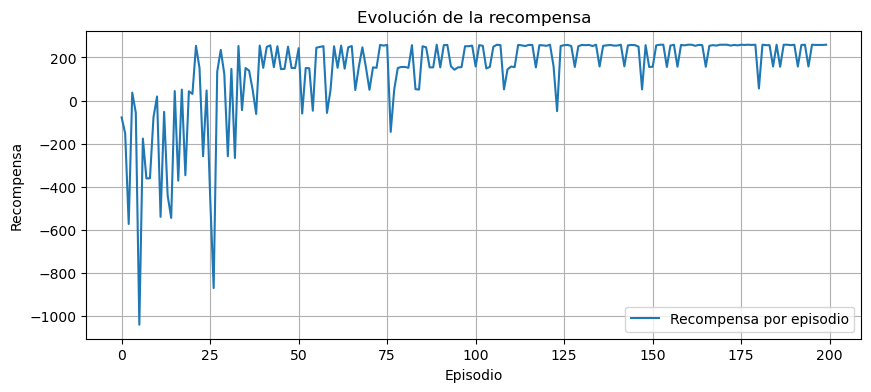

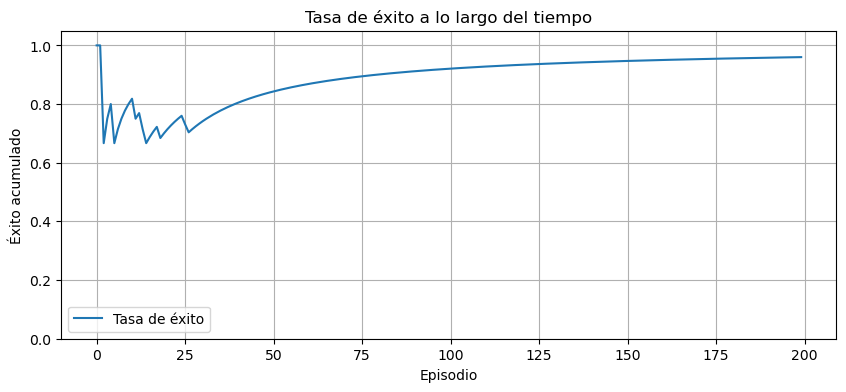

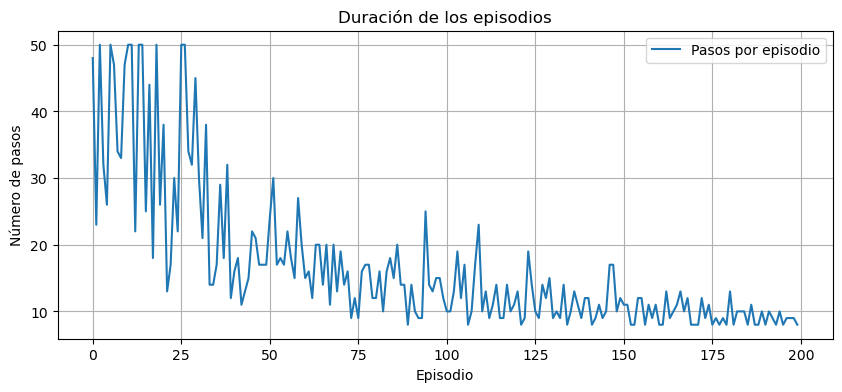

In [147]:
import matplotlib.pyplot as plt

# Recompensa por episodio
plt.figure(figsize=(10, 4))
plt.plot(reward_history, label="Recompensa por episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Evolución de la recompensa")
plt.legend()
plt.grid()
plt.show()

# Tasa de éxito acumulada
plt.figure(figsize=(10, 4))
success_rate = np.cumsum(success_history) / np.arange(1, episodes + 1)
plt.plot(success_rate, label="Tasa de éxito")
plt.xlabel("Episodio")
plt.ylabel("Éxito acumulado")
plt.title("Tasa de éxito a lo largo del tiempo")
plt.ylim(0, 1.05)
plt.legend()
plt.grid()
plt.show()

# Pasos por episodio
plt.figure(figsize=(10, 4))
plt.plot(steps_history, label="Pasos por episodio")
plt.xlabel("Episodio")
plt.ylabel("Número de pasos")
plt.title("Duración de los episodios")
plt.legend()
plt.grid()
plt.show()


Estado inicial:


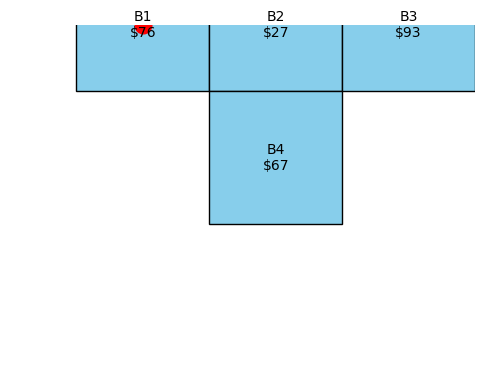

Paso 1: Acción = extract
Extrajo B1 ((0, 0)) con valor 76
Recompensa: 76, ¿Terminado?: False
Paso 2: Acción = right
Movimiento de (0, 0) a (0, 1)
Recompensa: -1, ¿Terminado?: False
Paso 3: Acción = extract
Extrajo B2 ((0, 1)) con valor 27
Recompensa: 27, ¿Terminado?: False
Paso 4: Acción = right
Movimiento de (0, 1) a (0, 2)
Recompensa: -1, ¿Terminado?: False
Paso 5: Acción = extract
Extrajo B3 ((0, 2)) con valor 93
Recompensa: 93, ¿Terminado?: False
Paso 6: Acción = left
Movimiento de (0, 2) a (0, 1)
Recompensa: -1, ¿Terminado?: False
Paso 7: Acción = down
Movimiento de (0, 1) a (1, 1)
Recompensa: -1, ¿Terminado?: False
Paso 8: Acción = right
Movimiento inválido a (1, 2) - fuera de la forma T
Recompensa: -1, ¿Terminado?: False
Paso 9: Acción = extract
Extrajo B4 ((1, 1)) con valor 67
Recompensa: 67, ¿Terminado?: True
¡Todos los bloques fueron extraídos correctamente!


In [148]:
env = SimpleUPLEnvironment(seed=123)  # Reinicia el entorno con la misma semilla
state = env.reset()

fig, ax = plt.subplots(figsize=(4, 4))
print(f"Estado inicial:")
env.render_matplotlib(ax=ax)  # Dibuja el entorno en matplotlib


for step in range(50):
    action = agent.choose_action(state)  # Selecciona acción según la Q-table entrenada
    print(f"Paso {step + 1}: Acción = {action}")  # Imprime acción elegida

    state, reward, done = env.step(action)  # Ejecuta acción
    print(f"Recompensa: {reward}, ¿Terminado?: {done}")  # Resultado

    if done:
        print("¡Todos los bloques fueron extraídos correctamente!")
        break

plt.show()
